# RFM and K-Means Comparison

## About Dataset
The dataset named Online Retail II includes the sales of a UK-based online store between 01/12/2009 -09/12/2011. The product catalog of this company includes souvenirs. It can also be considered as promotional products. There is also information that most of its customers are wholesalers.

## Variables
 **InvoiceNo**  : Invoice number. The unique number of each transaction, namely the invoice. If this code starts                     with C, it means that the operation has been cancelled.<br> 
 **StockCode**  : Product code. Unique number for each product<br>
 **Description**: Product name <br>
 **Quantity**   : Number of products. It expresses how many of the products on the invoices have been sold. <br>
 **InvoiceDate**: Invoice date and time <br>
 **UnitPrice**  : Product price (in GBP)<br>
 **CustomerID** : Unique customer number <br>
 **Country**    : Country where the customer lives


In [1]:
# Essential imports

import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Reading dataset and copying it because reading takes too long.

df_ = pd.read_excel("/Users/aslihankalyonkat/Desktop/DSMLBC/datasets/Online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

In [3]:
# Head of dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Calculating the total price for the products on the invoice
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [5]:
# Dropping nan values
df.dropna(inplace=True)

In [6]:
# C means returned invoices.
df = df[~df["Invoice"].astype(str).str.contains("C", na=False)]

## Calculating RFM Metrics

In [7]:
# The analysis date was accepted 2 days after the last purchase.
today_date = dt.datetime(2011, 12, 11)

# recency, frequency and monetary metrics
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})

rfm.columns = ['recency', 'frequency', "monetary"]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [8]:
# Monetary > 0 filter
rfm = rfm[(rfm['monetary'] > 0)]

In [9]:
# Calculating rfm scores
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score
Customer ID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,3,7,4310.00,5,5,5
12348.0,76,4,1797.24,2,4,4
12349.0,19,1,1757.55,4,1,4
12350.0,311,1,334.40,1,1,2


In [10]:
# Calculating RFM Score
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,311,1,334.40,1,1,2,11


In [11]:
# Segment names
seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

In [12]:
# Creating segments
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm = rfm[["recency", "frequency", "monetary", "segment"]]
rfm.head()

,recency,frequency,monetary,segment
Customer ID,,,,
12346.0,326,1,77183.60,hibernating
12347.0,3,7,4310.00,champions
12348.0,76,4,1797.24,at_risk
12349.0,19,1,1757.55,promising
12350.0,311,1,334.40,hibernating


<AxesSubplot:ylabel='segment'>

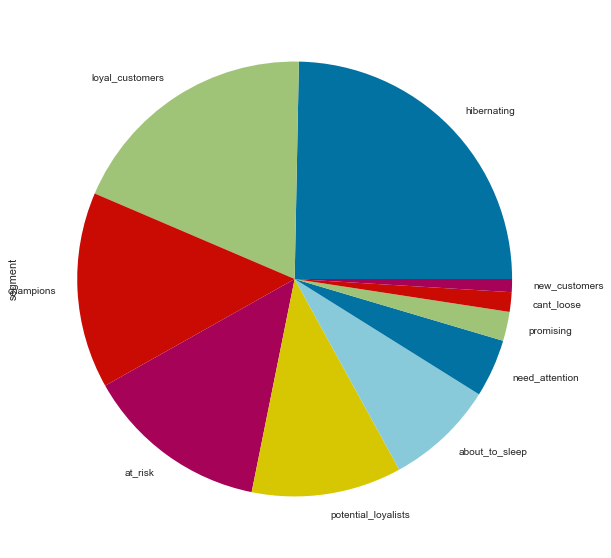

In [13]:
# visualization of segments
rfm["segment"].value_counts().plot.pie(y='segment', figsize=(10, 10))

## K-Means Clustering

In [14]:
# Standar scaler
sc = MinMaxScaler((0, 1))
segment_data = pd.DataFrame(sc.fit_transform(rfm[["recency", "frequency", "monetary"]]),
                            index=rfm.index, columns=["Recency", "Frequency", "Monetary"])
segment_data.reset_index(inplace=True)
segment_data.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,0.871314,0.000000,0.275443
1,12347.0,0.005362,0.028708,0.015368
2,12348.0,0.201072,0.014354,0.006401
3,12349.0,0.048257,0.000000,0.006259
4,12350.0,0.831099,0.000000,0.001180


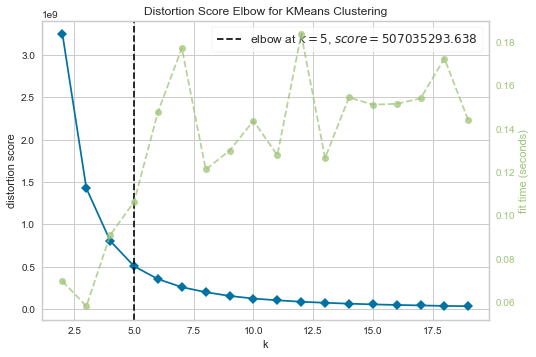

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Finding optimum numbers of clusters
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(segment_data)
elbow.show()

In [16]:
# Creating clusters
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(segment_data)
segment_data["clusters"] = kmeans.labels_
segment_data.head()

,Customer ID,Recency,Frequency,Monetary,clusters
0,12346.0,0.871314,0.000000,0.275443,1
1,12347.0,0.005362,0.028708,0.015368,1
2,12348.0,0.201072,0.014354,0.006401,1
3,12349.0,0.048257,0.000000,0.006259,1
4,12350.0,0.831099,0.000000,0.001180,1


## Comparing RFM metrics and Clusters

In [17]:
# Mean values of metrics in cluster and segment breakdown
segmentation = rfm.merge(segment_data, on="Customer ID")
segmentation[["segment", "clusters", "recency", "frequency", "monetary"]].groupby(
    ["clusters", "segment"]).agg(["mean"])

recency  frequency     monetary
                                    mean       mean         mean
clusters segment                                                
0        about_to_sleep        54.238806   1.000000   371.601493
         at_risk              153.873134   2.776119   845.135970
         cant_loose           116.235294   9.058824  3123.376471
         champions              6.266129  10.169355  4293.247661
         hibernating          217.214286   1.000000   355.987698
         loyal_customers       34.538835   5.927184  2508.043592
         need_attention        51.030303   2.000000   776.843636
         potential_loyalists   18.505263   1.589474  2267.960316
1        about_to_sleep        55.431579   1.410526   755.416842
         at_risk              115.283582   3.552239  1450.527478
         cant_loose           158.625000   7.000000  4280.723750
         champions              6.117188  13.882812  5439.029453
         hibernating          206.719723   1.283737   879.030727
         loyal_customers       31.862069   7.296552  5037.822897
         need_attention        52.625000   3.000000  2281.442500
         new_customers          7.222222   1.000000   316.040556
         potential_loyalists   17.010204   2.408163   987.072347
         promising             23.225806   1.000000   347.699032
2        about_to_sleep        51.673077   1.000000   292.747115
         at_risk              159.608696   2.746377   793.128406
         cant_loose           156.214286   9.285714  2320.340000
         champions              6.129771  12.267176  8912.409847
         hibernating          228.875648   1.000000   301.666166
         loyal_customers       33.817143   6.114286  2039.121886
         need_attention        49.161290   2.000000   601.390645
         potential_loyalists   17.443478   1.539130   412.540609
3        about_to_sleep        51.818182   1.000000   338.791515
         at_risk              164.978723   2.836879  1494.279787
         cant_loose           139.545455   8.363636  2471.648182
         champions              7.009804  13.519608  7329.107157
         hibernating          221.194030   1.000000   326.879154
         loyal_customers       35.822368   6.769737  2560.395664
         need_attention        52.055556   2.388889   733.744259
         new_customers          7.750000   1.000000   651.720833
         potential_loyalists   17.231579   2.263158   804.592947
         promising             23.756757   1.000000   290.040541
4        about_to_sleep        52.208333   1.250000   443.014306
         at_risk              155.433628   2.814159   996.023894
         cant_loose           108.461538   7.384615  2241.672308
         champions              6.412162  12.405405  8090.797703
         hibernating          219.160194   1.131068   391.179908
         loyal_customers       31.397163   6.588652  2501.072128
         need_attention        55.528302   2.452830   895.324340
         new_customers          7.416667   1.000000   232.963333
         potential_loyalists   16.703704   2.395062   838.069506
         promising             23.500000   1.000000   235.637692

In [18]:
# Numbers of segments in clusters
pd.DataFrame(segmentation[["segment", "clusters"]].groupby(["clusters", "segment"])["segment"].agg("count"))

segment
clusters segment                     
0        about_to_sleep            67
         at_risk                  134
         cant_loose                17
         champions                124
         hibernating              182
         loyal_customers          206
         need_attention            33
         potential_loyalists       95
1        about_to_sleep            95
         at_risk                   67
         cant_loose                 8
         champions                128
         hibernating              289
         loyal_customers          145
         need_attention            16
         new_customers             18
         potential_loyalists       98
         promising                 31
2        about_to_sleep            52
         at_risk                  138
         cant_loose                14
         champions                131
         hibernating              193
         loyal_customers          175
         need_attention            31
         potential_loyalists      115
3        about_to_sleep            66
         at_risk                  141
         cant_loose                11
         champions                102
         hibernating              201
         loyal_customers          152
         need_attention            54
         new_customers             12
         potential_loyalists       95
         promising                 37
4        about_to_sleep            72
         at_risk                  113
         cant_loose                13
         champions                148
         hibernating              206
         loyal_customers          141
         need_attention            53
         new_customers             12
         potential_loyalists       81
         promising                 26

<AxesSubplot:xlabel='segment', ylabel='clusters'>

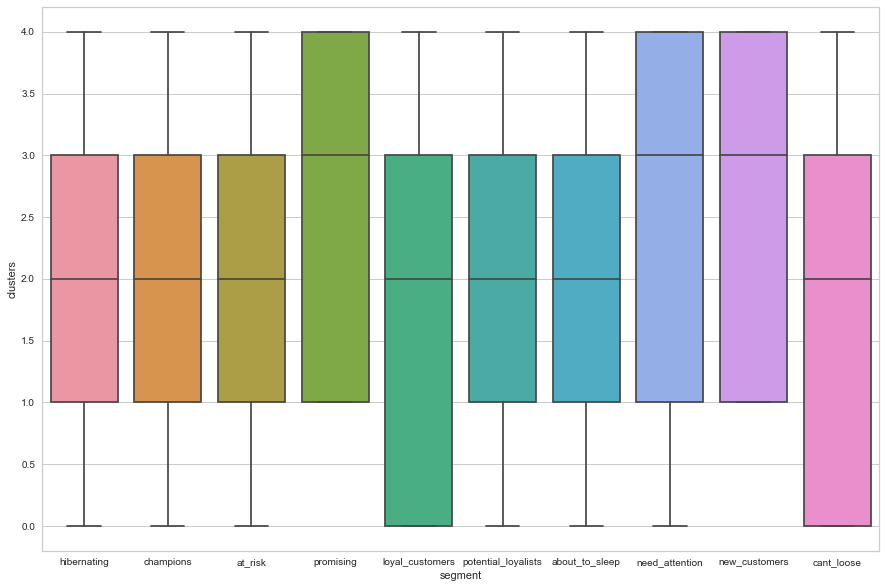

In [19]:
# Visualization of cluster and segment intersections
plt.figure(figsize=(15,10))
sns.boxplot(x = 'segment',
           y = 'clusters',
           data = segmentation)
